<a href="https://colab.research.google.com/github/Eshan133/bone_segmentation_naamii/blob/main/Bone_Segmentation_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install nibabel plotly kaleido

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import nibabel as nib
import numpy as np

img = nib.load('/content/drive/MyDrive/3702_left_knee.nii.gz')

data = img.get_fdata()

print("Data shape:", data.shape)  # Should be (512, 512, 216)
print("Data type:", data.dtype)
print("Data min/max:", data.min(), data.max())
print("Data mean/std:", data.mean(), data.std())
print("Data percentiles (10th, 50th, 90th):", np.percentile(data, [10, 50, 90]))

In [ ]:
img = nib.load('/content/drive/MyDrive/3702_left_knee.nii.gz')

In [ ]:
data = img.get_fdata()

In [ ]:
print("Data shape:", data.shape)  # Should be (512, 512, 216)
print("Data type:", data.dtype)
print("Data min/max:", data.min(), data.max())
print("Data mean/std:", data.mean(), data.std())
print("Data percentiles (10th, 50th, 90th):", np.percentile(data, [10, 50, 90]))

Data shape: (512, 512, 216)
Data type: float64
Data min/max: -3024.0 1769.0
Data mean/std: -1112.6603342868664 725.6593123483354
Data percentiles (10th, 50th, 90th): [-3024. -1000.  -880.]


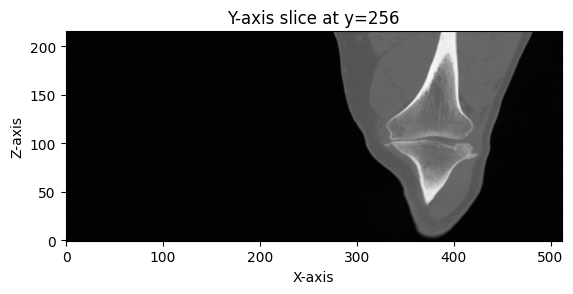

<Figure size 640x480 with 0 Axes>

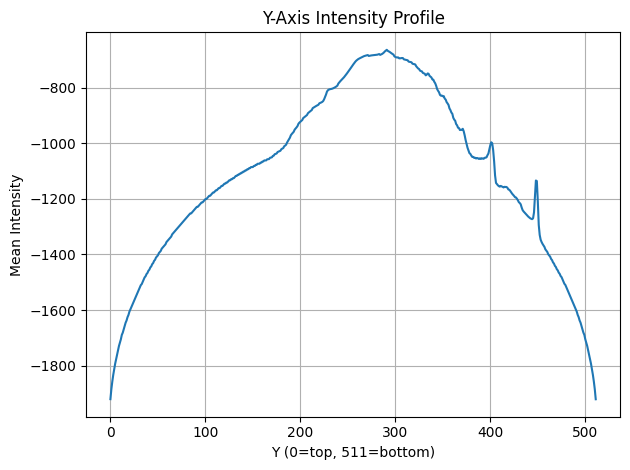

In [ ]:
# Y-axis slice (coronal, x-z plane)
y_idx = data.shape[1] // 2  # y=256
slice_y = data[:, y_idx, :]

# Display the slice
plt.imshow(slice_y.T, cmap='gray', origin='lower')
plt.title(f"Y-axis slice at y={y_idx}")
plt.xlabel("X-axis")
plt.ylabel("Z-axis")
plt.show()


plt.tight_layout()
plt.show()


# Check content along each axis (mean intensity profiles)
y_profile = np.mean(data, axis=(0, 2))  # Mean over x, z for each y


plt.plot(y_profile)
plt.title("Y-Axis Intensity Profile")
plt.xlabel("Y (0=top, 511=bottom)")
plt.ylabel("Mean Intensity")
plt.grid(True)


plt.tight_layout()
plt.show()

In [ ]:
# import os
# import numpy as np
# import nibabel as nib
# import matplotlib.pyplot as plt
# from PIL import Image
# import zipfile

# # Output folder for slices
# output_folder = "/content/y_slices"
# os.makedirs(output_folder, exist_ok=True)

# # Save each slice
# for y in range(data.shape[1]):  # y-axis: 0 to 511
#     slice_2d = data[:, y, :]     # shape (512, 216)

#     # Normalize slice for saving as image (0-255)
#     slice_norm = 255 * (slice_2d - np.min(slice_2d)) / (np.ptp(slice_2d) + 1e-5)
#     slice_img = Image.fromarray(np.flipud(slice_norm.T).astype(np.uint8))  # Transpose + vertical flip

#     # Save the image
#     slice_img.save(f"{output_folder}/slice_y_{y:03d}.png")

# print("✅ All slices saved!")

# # Zip the folder
# zip_path = "/content/y_slices.zip"
# with zipfile.ZipFile(zip_path, 'w') as zipf:
#     for root, _, files in os.walk(output_folder):
#         for file in files:
#             zipf.write(os.path.join(root, file),
#                        arcname=os.path.relpath(os.path.join(root, file), output_folder))

# print("✅ Zip file created!")

# # Download the zip file
# from google.colab import files
# files.download(zip_path)

✅ All slices saved!
✅ Zip file created!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

----
## Task 1.1
- CT scans are 3D volumetric images where each voxel has an intensity value in Hounsfield Units (HU).
- Bones typically have high HU values (e.g., 200–1000 HU), while soft tissues are lower (e.g., -100 to 100 HU).

Techniques for Segmentation:
-Thresholding: Select voxels within a specific HU range for bones.
Connected
- Component Analysis: Identify distinct bone regions (e.g., femur vs. tibia).
- Morphological Operations: Clean up noise or fill small gaps in the mask.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import nibabel as nib
import numpy as np

In [5]:
img = nib.load('/content/drive/MyDrive/3702_left_knee.nii.gz')

In [6]:
data = img.get_fdata()

In [7]:
print("Data shape:", data.shape)  # Should be (512, 512, 216)
print("Data type:", data.dtype)
print("Data min/max:", data.min(), data.max())
print("Data mean/std:", data.mean(), data.std())
print("Data percentiles (10th, 50th, 90th):", np.percentile(data, [10, 50, 90]))

Data shape: (512, 512, 216)
Data type: float64
Data min/max: -3024.0 1769.0
Data mean/std: -1112.6603342868664 725.6593123483354
Data percentiles (10th, 50th, 90th): [-3024. -1000.  -880.]


In [ ]:
import nibabel as nib
import numpy as np
from scipy.ndimage import label, binary_closing
import os

def load_ct_scan(file_path):
    """Load a CT scan and return the image array and NIfTI object."""
    img = nib.load(file_path)
    data = img.get_fdata()
    return data, img

def threshold_slice(data, lower_hu=200, upper_hu=1000):
    """Apply thresholding to isolate bone voxels."""
    return (data >= lower_hu) & (data <= upper_hu)

def segment_along_y_axis(data):
    """Segment bones slice-by-slice along the y-axis."""
    ny = data.shape[1]  # Number of slices along y-axis
    bone_mask = np.zeros_like(data, dtype=np.uint8)  # 3D mask

    # Process each y-slice
    for y in range(ny):
        slice_data = data[:, y, :]  # 2D slice (x, z)
        slice_mask = threshold_slice(slice_data)
        bone_mask[:, y, :] = slice_mask.astype(np.uint8)

    # Apply 3D connected component analysis to ensure continuity
    labeled_array, num_features = label(bone_mask)

    # Identify two largest components (assumed to be femur and tibia)
    sizes = np.bincount(labeled_array.ravel())[1:]  # Ignore background
    if len(sizes) < 2:
        raise ValueError("Fewer than two bone components detected.")
    largest_components = np.argsort(sizes)[-2:] + 1  # Indices of two largest

    # Create initial masks
    mask1 = (labeled_array == largest_components[0]).astype(np.uint8)
    mask2 = (labeled_array == largest_components[1]).astype(np.uint8)

    # Separate femur and tibia based on z-coordinate (inferior-superior)
    # Femur is higher (smaller z), tibia is lower (larger z)
    centroid1 = np.mean(np.where(mask1), axis=1)  # [x, y, z]
    centroid2 = np.mean(np.where(mask2), axis=1)

    # Alternative: Use y-coordinate if needed (anterior-posterior)
    # Comment out z-based and uncomment y-based if y-axis is preferred
    if centroid1[2] < centroid2[2]:
        femur_mask, tibia_mask = mask1, mask2
    else:
        femur_mask, tibia_mask = mask2, mask1

    # Optional: Use y-coordinate for separation
    # if centroid1[1] < centroid2[1]:
    #     femur_mask, tibia_mask = mask1, mask2
    # else:
    #    –

    return femur_mask, tibia_mask

def refine_mask(mask):
    """Apply morphological operations to clean the mask."""
    # Apply binary closing to fill small holes
    return binary_closing(mask, structure=np.ones((3, 3, 3))).astype(np.uint8)

def save_mask(mask, template_img, output_path):
    """Save the mask as a .nii.gz file."""
    mask_img = nib.Nifti1Image(mask, template_img.affine, template_img.header)
    nib.save(mask_img, output_path)


In [ ]:
# Define paths
input_path = "/content/drive/MyDrive/3702_left_knee.nii.gz"  # Update with actual path
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)
femur_output = os.path.join(output_dir, "femur_mask.nii.gz")
tibia_output = os.path.join(output_dir, "tibia_mask.nii.gz")

# Step 1: Load CT scan
print("Loading CT scan...")
data, img = load_ct_scan(input_path)

# Step 2: Segment along y-axis
print("Segmenting bones along y-axis...")
femur_mask, tibia_mask = segment_along_y_axis(data)

# Step 3: Refine masks
print("Refining masks...")
femur_mask = refine_mask(femur_mask)
tibia_mask = refine_mask(tibia_mask)

# Step 4: Save masks
print("Saving masks...")
save_mask(femur_mask, img, femur_output)
save_mask(tibia_mask, img, tibia_output)
print(f"Saved masks to {femur_output} and {tibia_output}")

Loading CT scan...
Segmenting bones along y-axis...
Refining masks...
Saving masks...
Saved masks to results/femur_mask.nii.gz and results/tibia_mask.nii.gz


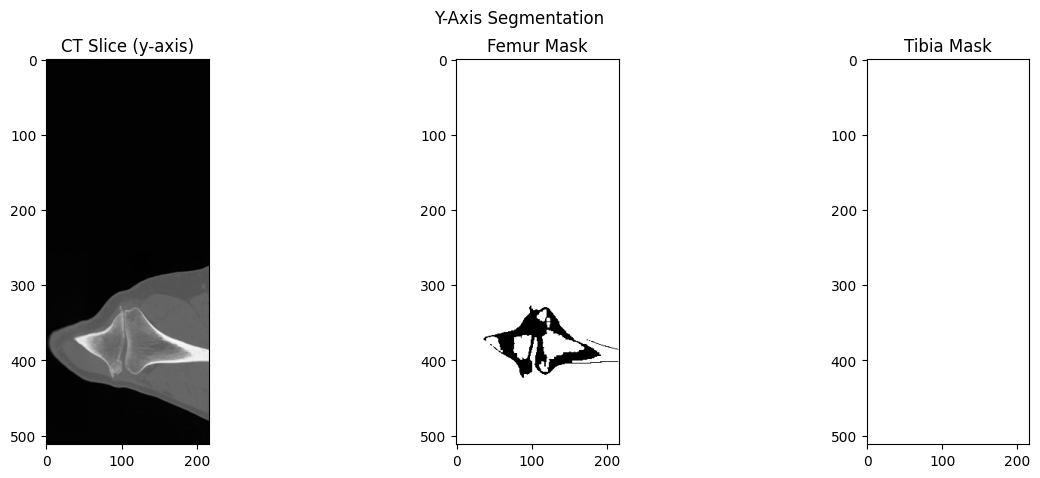

In [ ]:
import matplotlib.pyplot as plt

def visualize_y_slice(data, femur_mask, tibia_mask, y_idx, title):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(data[:, y_idx, :], cmap="gray")
    plt.title("CT Slice (y-axis)")
    plt.subplot(1, 3, 2)
    plt.imshow(femur_mask[:, y_idx, :], cmap="binary")
    plt.title("Femur Mask")
    plt.subplot(1, 3, 3)
    plt.imshow(tibia_mask[:, y_idx, :], cmap="binary")
    plt.title("Tibia Mask")
    plt.suptitle(title)
    plt.show()

# Add to main() after segmentation
visualize_y_slice(data, femur_mask, tibia_mask, data.shape[1] // 2, "Y-Axis Segmentation")

### Slice-by-Slice Segmentation (My Idea)
This method works but has limitations:

Pros:
- Simpler to implement.
- Can be used with 2D CNNs if you’re doing deep learning.

Cons:
- May result in inconsistent masks across slices.
- Ignores 3D structure continuity.
- Hard to differentiate tibia/femur when overlap exists in 2D.

| Approach                 | Use Case                    | Tools             | Accuracy |
| ------------------------ | --------------------------- | ----------------- | -------- |
| **nnU-Net (3D)**         | Best overall, generalizable | nnU-Net           | ⭐⭐⭐⭐⭐    |
| **MONAI + 3D U-Net**     | Custom pipelines            | PyTorch + MONAI   | ⭐⭐⭐⭐     |
| **Classical Processing** | Simpler, non-ML             | SimpleITK, OpenCV | ⭐⭐⭐      |
| **Slice-by-Slice**       | Simpler, but less robust    | 2D U-Net          | ⭐⭐       |


In [8]:
import nibabel as nib
import numpy as np
import cv2
from skimage import measure
from tqdm import tqdm
import os

In [9]:
segmentation_mask = np.zeros_like(data, dtype=np.uint8)

In [10]:
# Process slices along y-axis (0 to 511)
for y in tqdm(range(data.shape[1])):  # y-axis
    slice_img = data[:, y, :]  # shape: (512, 256)

    # Normalize to 0–255
    slice_norm = 255 * (slice_img - np.min(slice_img)) / (np.ptp(slice_img) + 1e-5)
    slice_uint8 = slice_norm.astype(np.uint8)

    # Preprocessing: blur
    blurred = cv2.GaussianBlur(slice_uint8, (5, 5), 0)

    # Thresholding
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morph operations
    kernel = np.ones((5, 5), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
    morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel, iterations=1)

    # Regionprops filtering
    labels = measure.label(morph)
    props = measure.regionprops(labels)
    slice_mask = np.zeros_like(slice_img, dtype=np.uint8)

    for prop in props:
        if prop.area > 1000:  # adjust based on your anatomy
            slice_mask[labels == prop.label] = 1

    # Insert the mask back into the 3D array
    segmentation_mask[:, y, :] = slice_mask


100%|██████████| 512/512 [00:03<00:00, 146.13it/s]


In [ ]:
# Save as NIfTI
seg_img = nib.Nifti1Image(segmentation_mask.astype(np.uint8), img.affine)
nib.save(seg_img, '/content/segmented_knee_yaxis_mask.nii.gz')
print("✅ Saved y-axis-based segmentation as 'segmented_knee_yaxis_mask.nii.gz'")


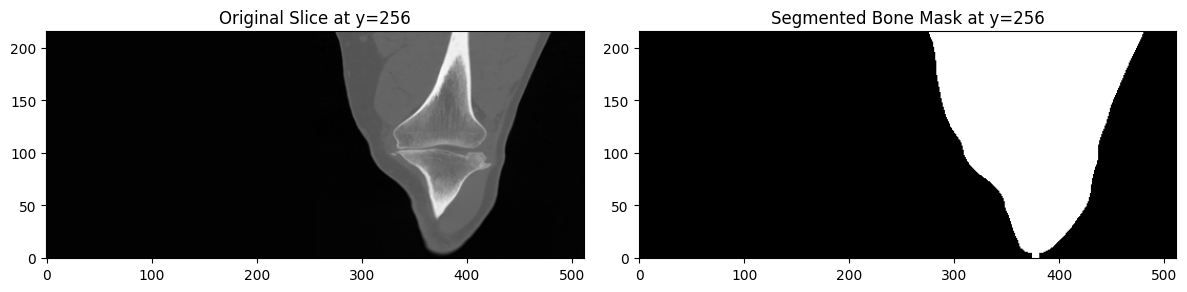

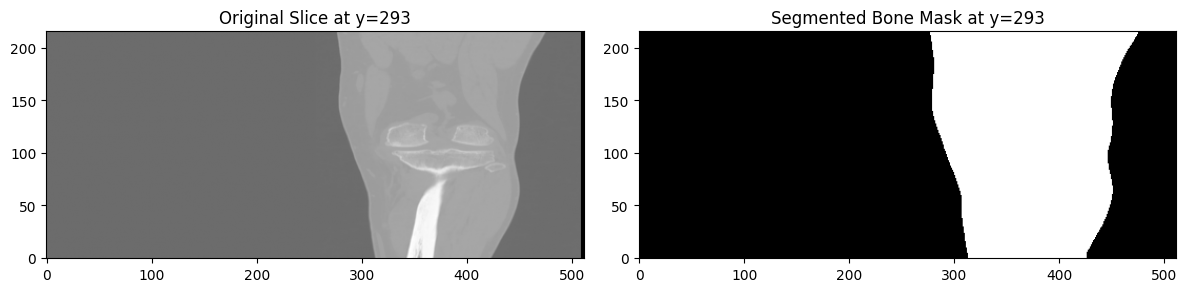

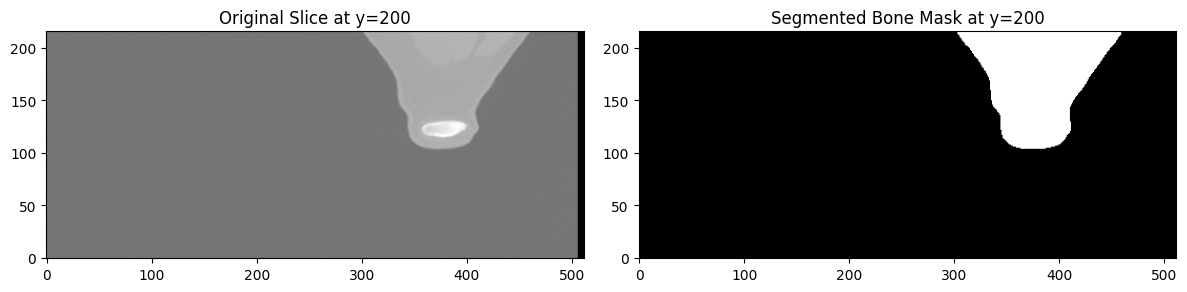

In [11]:
import matplotlib.pyplot as plt

def visualize_y_slice(y_index):
    """Visualizes original and segmented data at a given y-slice index"""
    original = data[:, y_index, :]          # shape: (512, 256)
    segmented = segmentation_mask[:, y_index, :]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.title(f'Original Slice at y={y_index}')
    plt.imshow(original.T, cmap='gray', origin='lower')  # transpose to (256, 512)

    plt.subplot(1, 2, 2)
    plt.title(f'Segmented Bone Mask at y={y_index}')
    plt.imshow(segmented.T, cmap='gray', origin='lower')

    plt.tight_layout()
    plt.show()

# Try visualizing a few different slices
visualize_y_slice(256)
visualize_y_slice(293)
visualize_y_slice(200)


In [12]:
import numpy as np
import nibabel as nib
from skimage import measure, morphology
from scipy.ndimage import label
import matplotlib.pyplot as plt
from tqdm import tqdm

In [13]:
# Prepare output masks
femur_mask = np.zeros_like(data, dtype=np.uint8)
tibia_mask = np.zeros_like(data, dtype=np.uint8)

# Loop over Y-axis (axis=1)
for y in tqdm(range(data.shape[1])):
    slice_img = data[:, y, :]  # axial slice

    # Step 1: Threshold for bone
    slice_bone = (slice_img >= 200) & (slice_img <= 1000)

    # Step 2: Connected components
    labeled, num_labels = label(slice_bone)

    if num_labels < 2:
        continue  # skip if not enough components

    # Step 3: Get two largest regions
    props = measure.regionprops(labeled)
    props = sorted(props, key=lambda x: x.area, reverse=True)

    femur_lbl = props[0].label
    tibia_lbl = props[1].label

    femur_mask[:, y, :][labeled == femur_lbl] = 1
    tibia_mask[:, y, :][labeled == tibia_lbl] = 1

# Step 4: Morphological cleanup (entire 3D volume)
from skimage.morphology import ball, binary_closing

femur_mask = binary_closing(femur_mask).astype(np.uint8)
tibia_mask = binary_closing(tibia_mask).astype(np.uint8)

# Save the masks
nib.save(nib.Nifti1Image(femur_mask, img.affine), '/content/femur_mask_yaxis.nii.gz')
nib.save(nib.Nifti1Image(tibia_mask, img.affine), '/content/tibia_mask_yaxis.nii.gz')

print("✅ Femur and tibia masks created by slicing along y-axis and saved.")

100%|██████████| 512/512 [00:01<00:00, 376.41it/s]


✅ Femur and tibia masks created by slicing along y-axis and saved.


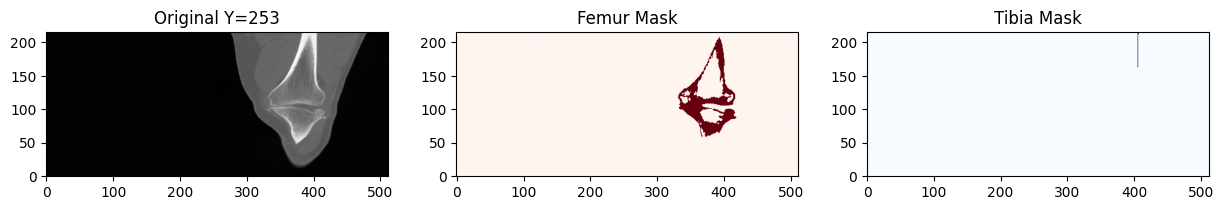

In [18]:
def show_y_slice(y=128):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title(f'Original Y={y}')
    plt.imshow(data[:, y, :].T, cmap='gray', origin='lower')

    plt.subplot(1, 3, 2)
    plt.title('Femur Mask')
    plt.imshow(femur_mask[:, y, :].T, cmap='Reds', origin='lower')

    plt.subplot(1, 3, 3)
    plt.title('Tibia Mask')
    plt.imshow(tibia_mask[:, y, :].T, cmap='Blues', origin='lower')
    plt.show()

show_y_slice(253)  # adjust y as needed


-----

In [31]:
!pip install nibabel numpy scipy scikit-image matplotlib

In [25]:
import nibabel as nib
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage import measure

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


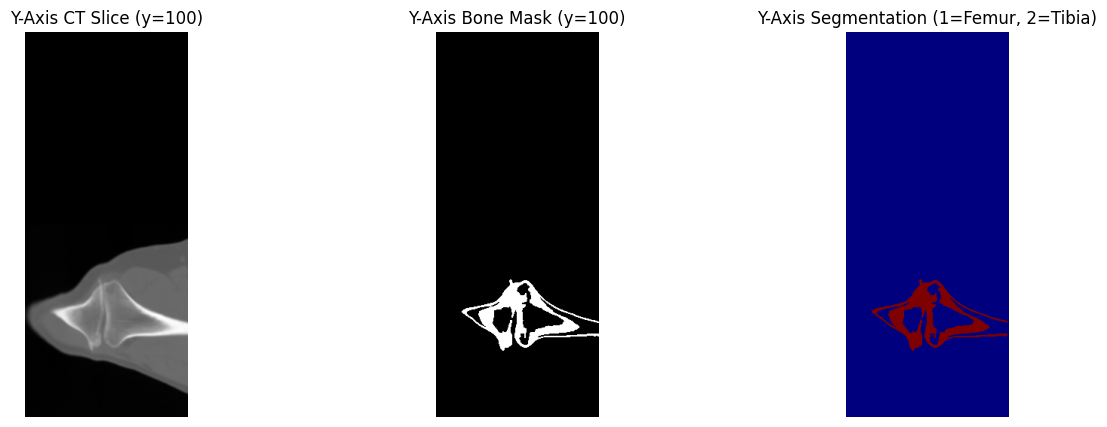

In [44]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install libraries
!pip install nibabel numpy scipy scikit-image matplotlib

# Import libraries
import nibabel as nib
import numpy as np
from scipy.ndimage import gaussian_filter, binary_closing, distance_transform_edt
from skimage import measure
from skimage.segmentation import watershed
import matplotlib.pyplot as plt

# Load the CT scan
img = nib.load("/content/drive/MyDrive/3702_left_knee.nii.gz")
data = img.get_fdata()

# Preprocess
data = gaussian_filter(data, sigma=1.0)
bone_mask = (data >= 200) & (data <= 1000).astype(np.uint8)

# Label connected components
labels = measure.label(bone_mask, connectivity=2)
regions = measure.regionprops(labels)
areas = [r.area for r in regions]
largest_indices = np.argsort(areas)[-2:]

# Initialize segmentation
segmentation = np.zeros_like(data, dtype=np.uint8)

# Check if bones are separated
if len(largest_indices) >= 2 and areas[largest_indices[0]] > 1000:  # Adjust threshold
    femur_mask = (labels == largest_indices[0] + 1).astype(np.uint8)
    tibia_mask = (labels == largest_indices[1] + 1).astype(np.uint8)
    segmentation[femur_mask > 0] = 1
    segmentation[tibia_mask > 0] = 2
else:
    print("Bones may be connected. Applying watershed.")
    # Create seeds for femur and tibia at y=100
    seeds = np.zeros_like(data, dtype=np.uint8)
    y_split = 100  # Split at y=100
    seeds[:, :y_split, :][bone_mask[:, :y_split, :] > 0] = 1  # Femur (y<100)
    seeds[:, y_split:, :][bone_mask[:, y_split:, :] > 0] = 2  # Tibia (y>=100)
    # Compute distance transform
    distance = distance_transform_edt(bone_mask)
    # Apply watershed
    segmentation = watershed(-distance, seeds, mask=bone_mask).astype(np.uint8)

# Smooth segmentation
segmentation = binary_closing(segmentation > 0, iterations=2).astype(np.uint8) * segmentation


seg = 256
# Visualize y-axis slice at y=100
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(data[:, seg, :], cmap='gray')
plt.title('Y-Axis CT Slice (y=100)')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(bone_mask[:, seg, :], cmap='gray')
plt.title('Y-Axis Bone Mask (y=100)')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(segmentation[:, seg, :], cmap='jet')
plt.title('Y-Axis Segmentation (1=Femur, 2=Tibia)')
plt.axis('off')
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


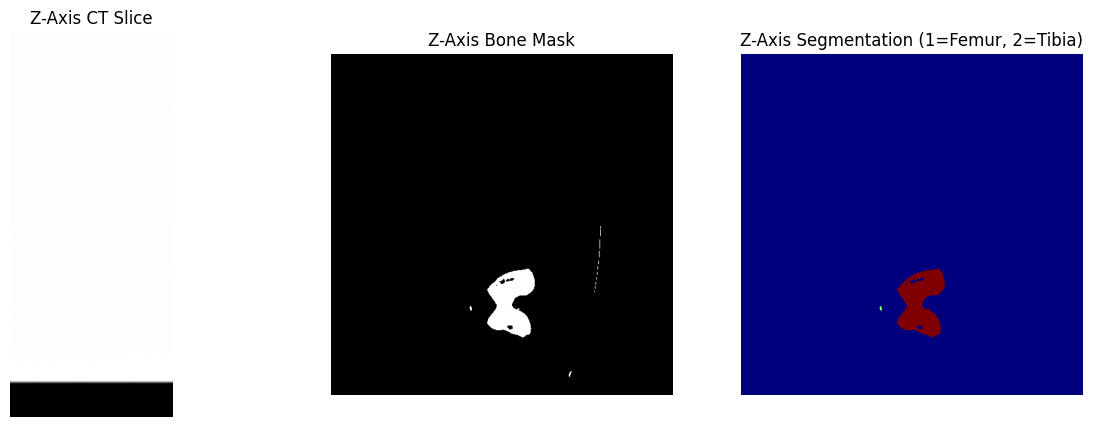

In [48]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install libraries
!pip install nibabel numpy scipy scikit-image matplotlib

# Import libraries
import nibabel as nib
import numpy as np
from scipy.ndimage import gaussian_filter, binary_closing
from skimage import measure
import matplotlib.pyplot as plt

# Load the CT scan
img = nib.load("/content/drive/MyDrive/3702_left_knee.nii.gz")
data = img.get_fdata()

# Preprocess
data = gaussian_filter(data, sigma=1.0)
bone_mask = (data >= 200) & (data <= 1000).astype(np.uint8)

# Label connected components
labels = measure.label(bone_mask, connectivity=2)
regions = measure.regionprops(labels)
areas = [r.area for r in regions]
largest_indices = np.argsort(areas)[-2:]

# Initialize segmentation
segmentation = np.zeros_like(data, dtype=np.uint8)

# Check if bones are separated
if len(largest_indices) >= 2 and areas[largest_indices[0]] > 1000:
    femur_mask = (labels == largest_indices[0] + 1).astype(np.uint8)
    tibia_mask = (labels == largest_indices[1] + 1).astype(np.uint8)
    segmentation[femur_mask > 0] = 1
    segmentation[tibia_mask > 0] = 2
else:
    print("Warning: Only one large bone component detected. Femur and tibia may be merged.")
    # Assign the largest component to femur (arbitrary choice)
    femur_mask = (labels == largest_indices[-1] + 1).astype(np.uint8)
    segmentation[femur_mask > 0] = 1

# Smooth segmentation
segmentation = binary_closing(segmentation > 0, iterations=2).astype(np.uint8) * segmentation

# Visualize z-axis slice
slice_idx = data.shape[2] // 2  # Middle slice (z=108)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(data[:, slice_idx, :], cmap='gray')
plt.title('Z-Axis CT Slice')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(bone_mask[:, :, slice_idx], cmap='gray')
plt.title('Z-Axis Bone Mask')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(segmentation[:, :, slice_idx], cmap='jet')
plt.title('Z-Axis Segmentation (1=Femur, 2=Tibia)')
plt.axis('off')
plt.show()

# # Save segmentation
# seg_nii = nib.Nifti1Image(segmentation, img.affine)
# nib.save(seg_nii, '/content/drive/MyDrive/3702_left_knee_segmented.nii.gz')

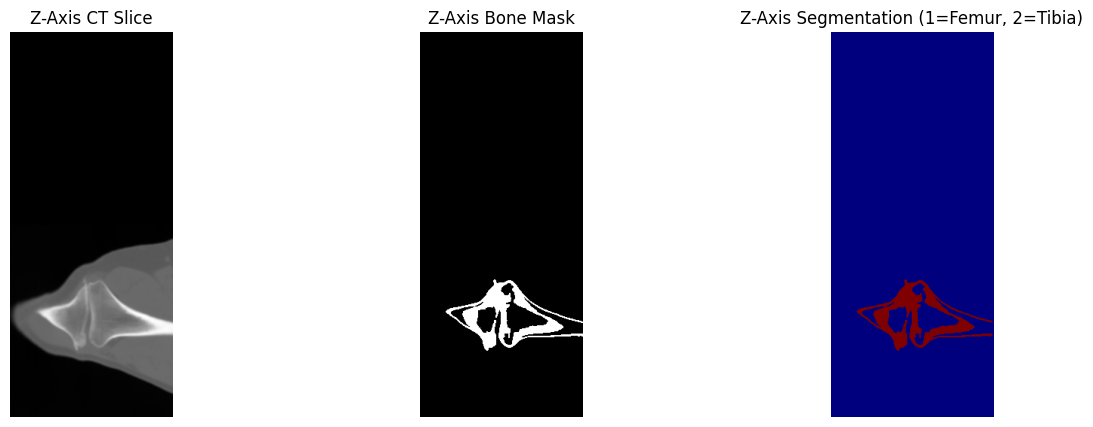

In [50]:
# Visualize z-axis slice
slice_idx = 256  # Middle slice (z=108)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(data[:, slice_idx, :], cmap='gray')
plt.title('Z-Axis CT Slice')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(bone_mask[:, slice_idx, :], cmap='gray')
plt.title('Z-Axis Bone Mask')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(segmentation[:, slice_idx, :], cmap='jet')
plt.title('Z-Axis Segmentation (1=Femur, 2=Tibia)')
plt.axis('off')
plt.show()

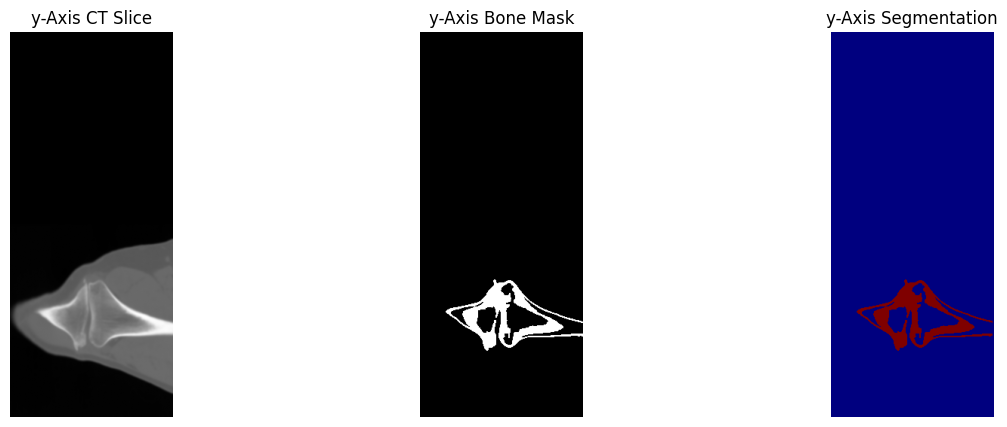

In [55]:
# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# # Install libraries
# !pip install nibabel numpy scipy scikit-image matplotlib

# # Import libraries
# import nibabel as nib
# import numpy as np
# from scipy.ndimage import gaussian_filter, binary_closing, distance_transform_edt
# from skimage import measure
# from skimage.segmentation import watershed
# import matplotlib.pyplot as plt

# Load the CT scan
img = nib.load('/content/drive/MyDrive/3702_left_knee.nii.gz')
data = img.get_fdata()

# Preprocess
data = gaussian_filter(data, sigma=1.0)
bone_mask = (data >= 200) & (data <= 1000).astype(np.uint8)

# Label connected components
labels = measure.label(bone_mask, connectivity=2)
regions = measure.regionprops(labels)
areas = [r.area for r in regions]
largest_indices = np.argsort(areas)[-2:]

# Initialize segmentation
segmentation = np.zeros_like(data, dtype=np.uint8)

# Check if bones are separated
if len(largest_indices) >= 2 and areas[largest_indices[0]] > 1000:
    femur_mask = (labels == largest_indices[0] + 1).astype(np.uint8)
    tibia_mask = (labels == largest_indices[1] + 1).astype(np.uint8)
    segmentation[femur_mask > 0] = 1
    segmentation[tibia_mask > 0] = 2

# Smooth segmentation
segmentation = binary_closing(segmentation > 0, iterations=2).astype(np.uint8) * segmentation

# Visualize z-axis slice
slice_idx = 256
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(data[:, slice_idx, :], cmap='gray')
plt.title('y-Axis CT Slice')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(bone_mask[:, slice_idx, :], cmap='gray')
plt.title('y-Axis Bone Mask')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(segmentation[:, slice_idx, :], cmap='jet')
plt.title('y-Axis Segmentation')
plt.axis('off')
plt.show()


----
## Trial -- 5

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import nibabel as nib
import numpy as np

def load_nii_file(file_path):
    """Load a .nii.gz file and return the image data and header."""
    img = nib.load('/content/drive/MyDrive/3702_left_knee.nii.gz')
    data = img.get_fdata()
    return data, img.header

def segment_along_y(data, y_min=None, y_max=None):
    """Segment the 3D volume along the y-axis."""
    if y_min is None or y_max is None:
        # Use the full y-axis range if not specified
        y_min, y_max = 0, data.shape[1]
    segmented_data = data[:, y_min:y_max, :]
    return segmented_data

def split_at_z(data, z_split=103):
    """Split the 3D volume into two parts at the specified z-value."""
    tibia_data = data[:, :, :z_split]  # Lower z-values (inferior, tibia)
    femur_data = data[:, :, z_split:]  # Higher z-values (superior, femur)
    return femur_data, tibia_data

def save_nii_file(data, header, output_path):
    """Save the 3D data as a .nii.gz file."""
    img = nib.Nifti1Image(data, affine=None, header=header)
    nib.save(img, output_path)

def main(input_file, output_femur, output_tibia, z_split=103, y_min=None, y_max=None):
    # Load the NIfTI file
    data, header = load_nii_file(input_file)

    # Confirm the data is 3D
    print(f"Input data shape: {data.shape} (3D volume)")
    print(f"Z-range: 0 to {data.shape[2]-1}")

    # Segment along y-axis (3D operation)
    segmented_data = segment_along_y(data, y_min, y_max)
    print(f"Segmented data shape: {segmented_data.shape} (3D volume)")

    # Split into femur and tibia at z=103
    femur_data, tibia_data = split_at_z(segmented_data, z_split)
    print(f"Femur data shape: {femur_data.shape} (3D volume, z={z_split} to {segmented_data.shape[2]-1})")
    print(f"Tibia data shape: {tibia_data.shape} (3D volume, z=0 to {z_split-1})")

    # Save the segmented volumes
    save_nii_file(femur_data, header, output_femur)
    save_nii_file(tibia_data, header, output_tibia)
    print(f"Saved femur segment (superior, z>={z_split}) to {output_femur}")
    print(f"Saved tibia segment (inferior, z<{z_split}) to {output_tibia}")

if __name__ == "__main__":
    # Define file paths and parameters
    input_file = "knee_ct_scan.nii.gz"  # Replace with your input file path
    output_femur = "femur_segment.nii.gz"
    output_tibia = "tibia_segment.nii.gz"
    z_split = 103  # Z-axis split point
    y_min = None  # Define y-axis range if needed (e.g., 50)
    y_max = None  # Define y-axis range if needed (e.g., 150)

    # Run the segmentation
    main(input_file, output_femur, output_tibia, z_split, y_min, y_max)

Input data shape: (512, 512, 216) (3D volume)
Z-range: 0 to 215
Segmented data shape: (512, 512, 216) (3D volume)
Femur data shape: (512, 512, 113) (3D volume, z=103 to 215)
Tibia data shape: (512, 512, 103) (3D volume, z=0 to 102)
Saved femur segment (superior, z>=103) to femur_segment.nii.gz
Saved tibia segment (inferior, z<103) to tibia_segment.nii.gz


Tibia data shape: (512, 512, 103) (x, y, z)
Femur data shape: (512, 512, 113) (x, y, z)


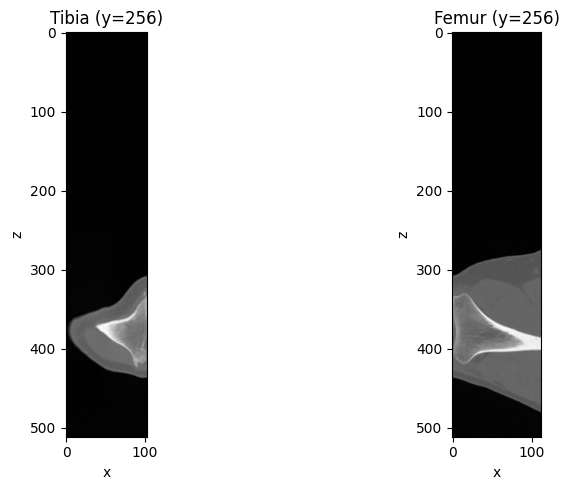

In [17]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def load_nii_file(file_path):
    """Load a .nii.gz file and return the image data as a NumPy array."""
    try:
        img = nib.load(file_path)
        data = img.get_fdata()
        if not isinstance(data, np.ndarray):
            raise ValueError(f"Loaded data from {file_path} is not a NumPy array.")
        return data
    except Exception as e:
        raise Exception(f"Error loading {file_path}: {str(e)}")

def plot_y_slices(tibia_data, femur_data, y_slice_femur=None, y_slice_tibia=None):
    """Plot 2D slices along the y-axis (x-z plane) from femur and tibia volumes without stretching."""
    # Verify inputs are NumPy arrays
    if not isinstance(femur_data, np.ndarray) or not isinstance(tibia_data, np.ndarray):
        raise ValueError("Femur and tibia data must be NumPy arrays.")

    # If y_slice is not specified, use the middle slice
    if y_slice_femur is None:
        y_slice_femur = femur_data.shape[1] // 2
    if y_slice_tibia is None:
        y_slice_tibia = tibia_data.shape[1] // 2

    # Validate y-slice indices
    if y_slice_femur >= femur_data.shape[1] or y_slice_femur < 0:
        raise ValueError(f"y_slice_femur ({y_slice_femur}) out of bounds for femur data with y-dimension {femur_data.shape[1]}.")
    if y_slice_tibia >= tibia_data.shape[1] or y_slice_tibia < 0:
        raise ValueError(f"y_slice_tibia ({y_slice_tibia}) out of bounds for tibia data with y-dimension {tibia_data.shape[1]}.")

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Plot tibia y-slice (x-z plane) without stretching
    ax1.imshow(tibia_data[:, y_slice_tibia, :], cmap='gray')
    ax1.set_title(f'Tibia (y={y_slice_tibia})')
    ax1.set_xlabel('x')
    ax1.set_ylabel('z')
    ax1.axis('on')  # Show axes for orientation

    # Plot femur y-slice (x-z plane) without stretching
    ax2.imshow(femur_data[:, y_slice_femur, :], cmap='gray')
    ax2.set_title(f'Femur (y={y_slice_femur})')
    ax2.set_xlabel('x')
    ax2.set_ylabel('z')
    ax2.axis('on')  # Show axes for orientation

    plt.tight_layout()
    plt.show()

def main(femur_file, tibia_file, y_slice_femur=None, y_slice_tibia=None):
    # Load the segmented files
    femur_data = load_nii_file(femur_file)
    tibia_data = load_nii_file(tibia_file)

    print(f"Tibia data shape: {tibia_data.shape} (x, y, z)")
    print(f"Femur data shape: {femur_data.shape} (x, y, z)")


    # Plot the y-axis slices
    plot_y_slices(tibia_data, femur_data, y_slice_femur, y_slice_tibia)

if __name__ == "__main__":
    # Define file paths
    femur_file = "femur_segment.nii.gz"  # Path to femur segment
    tibia_file = "tibia_segment.nii.gz"  # Path to tibia segment
    y_slice_femur = None  # Specify y-slice or use middle slice
    y_slice_tibia = None  # Specify y-slice or use middle slice

    # Run the visualization
    main(femur_file, tibia_file, y_slice_femur, y_slice_tibia)

Femur data shape: (512, 512, 113) (x, y, z, z>=103)
Tibia data shape: (512, 512, 103) (x, y, z, z<103)


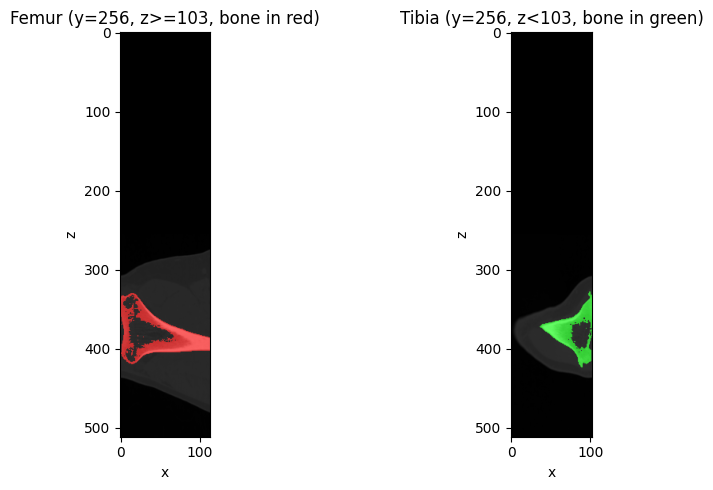

In [18]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def load_nii_file(file_path):
    """Load a .nii.gz file and return the image data as a NumPy array."""
    try:
        img = nib.load(file_path)
        data = img.get_fdata()
        if not isinstance(data, np.ndarray):
            raise ValueError(f"Loaded data from {file_path} is not a NumPy array.")
        return data
    except Exception as e:
        raise Exception(f"Error loading {file_path}: {str(e)}")

def segment_bone(data, threshold=200):
    """Segment bone regions using intensity thresholding."""
    return data > threshold

def create_colored_slice(data, y_slice, bone_mask, color_rgb):
    """Create a colored slice with bone regions highlighted."""
    # Extract the y-slice
    slice_data = data[:, y_slice, :]
    slice_mask = bone_mask[:, y_slice, :]

    # Normalize slice for grayscale background (0 to 1)
    slice_min, slice_max = np.min(slice_data), np.max(slice_data)
    if slice_max > slice_min:
        slice_normalized = (slice_data - slice_min) / (slice_max - slice_min)
    else:
        slice_normalized = np.zeros_like(slice_data)

    # Create RGB image: grayscale background
    rgb_slice = np.stack([slice_normalized, slice_normalized, slice_normalized], axis=-1)

    # Overlay colored bone regions
    alpha = 0.6  # Transparency for bone overlay
    for i in range(3):  # RGB channels
        rgb_slice[:, :, i] = (1 - alpha) * rgb_slice[:, :, i] + alpha * slice_mask * color_rgb[i]

    return rgb_slice

def plot_y_slices(femur_data, tibia_data, y_slice_femur=None, y_slice_tibia=None, bone_threshold=200):
    """Plot y-axis slices with femur bone in red and tibia bone in green."""
    # Verify inputs are NumPy arrays
    if not isinstance(femur_data, np.ndarray) or not isinstance(tibia_data, np.ndarray):
        raise ValueError("Femur and tibia data must be NumPy arrays.")

    # If y_slice is not specified, use the middle slice
    if y_slice_femur is None:
        y_slice_femur = femur_data.shape[1] // 2
    if y_slice_tibia is None:
        y_slice_tibia = tibia_data.shape[1] // 2

    # Validate y-slice indices
    if y_slice_femur >= femur_data.shape[1] or y_slice_femur < 0:
        raise ValueError(f"y_slice_femur ({y_slice_femur}) out of bounds for femur data with y-dimension {femur_data.shape[1]}.")
    if y_slice_tibia >= tibia_data.shape[1] or y_slice_tibia < 0:
        raise ValueError(f"y_slice_tibia ({y_slice_tibia}) out of bounds for tibia data with y-dimension {tibia_data.shape[1]}.")

    # Segment bone regions
    femur_bone_mask = segment_bone(femur_data, bone_threshold)
    tibia_bone_mask = segment_bone(tibia_data, bone_threshold)

    # Create colored slices
    femur_rgb = create_colored_slice(femur_data, y_slice_femur, femur_bone_mask, color_rgb=[1, 0, 0])  # Red for femur
    tibia_rgb = create_colored_slice(tibia_data, y_slice_tibia, tibia_bone_mask, color_rgb=[0, 1, 0])  # Green for tibia

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Plot femur y-slice with red bone
    ax1.imshow(femur_rgb)
    ax1.set_title(f'Femur (y={y_slice_femur}, z>={103}, bone in red)')
    ax1.set_xlabel('x')
    ax1.set_ylabel('z')
    ax1.axis('on')  # Show axes for orientation

    # Plot tibia y-slice with green bone
    ax2.imshow(tibia_rgb)
    ax2.set_title(f'Tibia (y={y_slice_tibia}, z<{103}, bone in green)')
    ax2.set_xlabel('x')
    ax2.set_ylabel('z')
    ax2.axis('on')  # Show axes for orientation

    plt.tight_layout()
    plt.show()

def main(femur_file, tibia_file, y_slice_femur=None, y_slice_tibia=None, bone_threshold=200):
    # Load the segmented files
    femur_data = load_nii_file(femur_file)
    tibia_data = load_nii_file(tibia_file)

    print(f"Femur data shape: {femur_data.shape} (x, y, z, z>={103})")
    print(f"Tibia data shape: {tibia_data.shape} (x, y, z, z<{103})")

    # Plot the y-axis slices with colored bone regions
    plot_y_slices(femur_data, tibia_data, y_slice_femur, y_slice_tibia, bone_threshold)

if __name__ == "__main__":
    # Define file paths
    femur_file = "femur_segment.nii.gz"  # Path to femur segment (z>=103)
    tibia_file = "tibia_segment.nii.gz"  # Path to tibia segment (z<103)
    y_slice_femur = None  # Specify y-slice or use middle slice
    y_slice_tibia = None  # Specify y-slice or use middle slice
    bone_threshold = 200  # Intensity threshold for bone segmentation

    # Run the visualization
    main(femur_file, tibia_file, y_slice_femur, y_slice_tibia, bone_threshold)

Femur data shape: (512, 512, 113) (x, y, z, z>=103)
Tibia data shape: (512, 512, 103) (x, y, z, z<103)
Combined data shape: (512, 512, 216) (x, y, z)
RGB mask shape: (512, 512, 216, 3) (x, y, z, 3)


Saved combined volume to combined_knee.nii.gz
Saved RGB bone mask to bone_mask_rgb.nii.gz


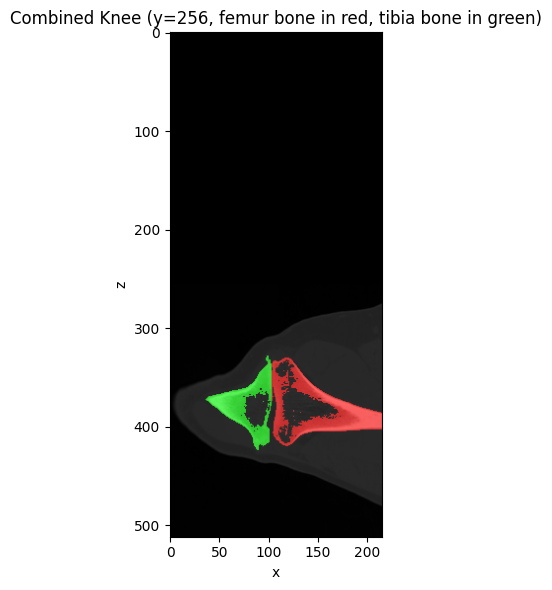

In [19]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def load_nii_file(file_path):
    """Load a .nii.gz file and return the image data and header."""
    try:
        img = nib.load(file_path)
        data = img.get_fdata()
        if not isinstance(data, np.ndarray):
            raise ValueError(f"Loaded data from {file_path} is not a NumPy array.")
        return data, img.header
    except Exception as e:
        raise Exception(f"Error loading {file_path}: {str(e)}")

def segment_bone(data, threshold=200):
    """Segment bone regions using intensity thresholding."""
    return data > threshold

def combine_volumes(tibia_data, femur_data, z_split=103):
    """Combine tibia (z<z_split) and femur (z>=z_split) into a single volume."""
    # Verify shapes match in x and y dimensions
    if tibia_data.shape[0] != femur_data.shape[0] or tibia_data.shape[1] != femur_data.shape[1]:
        raise ValueError("Tibia and femur volumes have mismatched x or y dimensions.")

    # Combine along z-axis
    combined_data = np.concatenate((tibia_data[:, :, :z_split], femur_data), axis=2)
    return combined_data

def create_colored_mask(tibia_data, femur_data, z_split=103, threshold=200):
    """Create a 3D RGB mask with femur bone in red and tibia bone in green."""
    # Segment bone regions
    tibia_bone_mask = segment_bone(tibia_data, threshold)
    femur_bone_mask = segment_bone(femur_data, threshold)

    # Initialize RGB mask (x, y, z, 3)
    combined_shape = (tibia_data.shape[0], tibia_data.shape[1], tibia_data.shape[2] + femur_data.shape[2], 3)
    rgb_mask = np.zeros(combined_shape, dtype=np.float32)

    # Assign green to tibia bone (z<z_split)
    rgb_mask[:, :, :z_split, 1] = tibia_bone_mask[:, :, :z_split]  # Green channel
    # Assign red to femur bone (z>=z_split)
    rgb_mask[:, :, z_split:, 0] = femur_bone_mask  # Red channel

    return rgb_mask

def save_nii_file(data, header, output_path, is_rgb=False):
    """Save 3D or 4D data as a .nii.gz file."""
    img = nib.Nifti1Image(data, affine=None, header=header)
    nib.save(img, output_path)

def plot_y_slice(combined_data, rgb_mask, y_slice):
    """Plot a y-axis slice with colored bone regions."""
    # Extract y-slice
    slice_data = combined_data[:, y_slice, :]
    slice_rgb = rgb_mask[:, y_slice, :, :]

    # Normalize slice for grayscale background
    slice_min, slice_max = np.min(slice_data), np.max(slice_data)
    if slice_max > slice_min:
        slice_normalized = (slice_data - slice_min) / (slice_max - slice_min)
    else:
        slice_normalized = np.zeros_like(slice_data)

    # Create RGB image: grayscale background
    rgb_slice = np.stack([slice_normalized, slice_normalized, slice_normalized], axis=-1)

    # Overlay colored bone regions
    alpha = 0.6  # Transparency for bone overlay
    for i in range(3):  # RGB channels
        rgb_slice[:, :, i] = (1 - alpha) * rgb_slice[:, :, i] + alpha * slice_rgb[:, :, i]

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(rgb_slice)
    ax.set_title(f'Combined Knee (y={y_slice}, femur bone in red, tibia bone in green)')
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.axis('on')
    plt.tight_layout()
    plt.show()

def main(femur_file, tibia_file, output_combined, output_mask, y_slice=None, z_split=103, bone_threshold=200):
    # Load segmented files
    femur_data, femur_header = load_nii_file(femur_file)
    tibia_data, tibia_header = load_nii_file(tibia_file)

    print(f"Femur data shape: {femur_data.shape} (x, y, z, z>={z_split})")
    print(f"Tibia data shape: {tibia_data.shape} (x, y, z, z<{z_split})")

    # Combine volumes
    combined_data = combine_volumes(tibia_data, femur_data, z_split)
    print(f"Combined data shape: {combined_data.shape} (x, y, z)")

    # Create colored bone mask
    rgb_mask = create_colored_mask(tibia_data, femur_data, z_split, bone_threshold)
    print(f"RGB mask shape: {rgb_mask.shape} (x, y, z, 3)")

    # Save combined volume and mask
    save_nii_file(combined_data, tibia_header, output_combined)
    save_nii_file(rgb_mask, tibia_header, output_mask, is_rgb=True)
    print(f"Saved combined volume to {output_combined}")
    print(f"Saved RGB bone mask to {output_mask}")

    # Plot a y-slice
    if y_slice is None:
        y_slice = combined_data.shape[1] // 2
    if y_slice >= combined_data.shape[1] or y_slice < 0:
        raise ValueError(f"y_slice ({y_slice}) out of bounds for y-dimension {combined_data.shape[1]}.")
    plot_y_slice(combined_data, rgb_mask, y_slice)

if __name__ == "__main__":
    # Define file paths
    femur_file = "femur_segment.nii.gz"  # Path to femur segment (z>=103)
    tibia_file = "tibia_segment.nii.gz"  # Path to tibia segment (z<103)
    output_combined = "combined_knee.nii.gz"  # Output combined volume
    output_mask = "bone_mask_rgb.nii.gz"  # Output RGB bone mask
    y_slice = None  # Specify y-slice or use middle slice
    z_split = 103  # Z-axis split point
    bone_threshold = 200  # Intensity threshold for bone

    # Run the combination and visualization
    main(femur_file, tibia_file, output_combined, output_mask, y_slice, z_split, bone_threshold)